# Skip-gram algorithm

## Introduction

In this tutorial you will learn about word vectors. Word vectors are numerical representations of words. Word vectors are a crucial transformation to enable machines to understand text. First you will learn why you need word vectors in natural language processing. Your understanding will then be reinforced with a simple yet colorful example explaining how word vectors make machines to learn text better. Then you will be introduced to a particular word vector algorithm known as **Skip-gram**. You will see how you can use free-flowing text in a supervised framework in order to train a neural network. Afterwords we will be scrutinizing the underlying mechanics of skip-gram by actually implementing the algorithm using Keras. Finally we will conclude the lesson.

## Why word vectors?
Word vectors are numerical vectors, i.e. sequence of numbers. However they are characterized by a special property,

> Words used in similar context will have similar word vectors, whereas words unlikely to be used in the same context will have very different word vectors.

In other words, word vectors capture meaning. Words used in a similar context usually have similar semantics, e.g. the word `cat` and `dog` are very similar and often used in very similar contexts, whereas the word `window` is used in a very different context. The context of a word means everything to a word, literally!

Due to this reason, word vectors are used as a base transformation for words in almost all modern NLP models. Such as,
* Machine translation
* Image caption generation
* Text generation
* Question answering
* Chatbots, etc.

## I am not very clear how word vectors help NLP models

Understandable! We still have not discussed much yet. But by the end of this lesson, you will understand the power of word vectors well. But let us try to grok how word vectors help NLP models with a high-level example. Assume a machine translation model, which looks like below. 

![Without word vectors](../images/wor2vec_lstm_anim_1.gif)

Now let us visualize the same system with word vectors

![With word vectors](../images/word2vec_lstm_anim_2.gif)

Having word vectors instead of a naive representation like (one-hot encoding) enables the MT model to behave consistently with the language.



## What are word vectors?

The meaning of a word relies on the context that word is being used. And this is the single most important concept in Word2vec algorithms. This was initially expressed by J.R. Firth; a British linguist.

> You shall know a word by the company it keeps - J.R. Firth

An illustration will do more justice here.

![Word vector sentence](../images/word2vec_sent.png)

Here in this *context*, the words `cat` and `dog` are more likely to be used than `window`. Therefore, you can conclude that `cat` and `dog` are more similar than `cat` and `window`, which makes sense. It is also sensible to assign vectors to `cat`, `dog`, and `window` as follows:

* `cat` $\leftarrow (0.41, 0.69, 0.10)$
* `dog` $\leftarrow (0.44, 0.60, 0.15)$
* `window` $\leftarrow (0.01, -0.51, 0.99)$

If I plot the above values in a graph, they would look like below.

![Word vectors on a graph](../images/word2vec_graph.png)

## Overview of Word2vec algorithms

Word2vec algorithms; a family of word vector algorithms we will be discussing in this tutorial will have the following structure:
* Getting a large corpus of text
* Using free-flowing text a supervised framework, i.e., define inputs and outputs from text
* Define an embedding layer that will contain word vectors of all the words in the vocabulary
* Define a loss function and a neural network to optimize the embedding layer

There are several popular word vector algorithms out there. You will be learning Skip-gram algorithm, which is one of the widely used ones.

## Skip-gram algorithm

You will now learn the Skip-gram algorithm. Skip-gram algorithm which is a Word2vec algorithm follows the above steps in order to learn the word embeddings. And we will see how each step is perfomed through an interactive exercise.


In [29]:

import collections
import requests
import math
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Embedding, Dense, Input
from tensorflow.python.keras.preprocessing.sequence import skipgrams
from tensorflow.python.keras.preprocessing.sequence import make_sampling_table
import tarfile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import nltk # standard preprocessing
import operator # sorting items in dictionary by value
from nltk.corpus import stopwords
#nltk.download('punkt')
#nltk.download('stopwords') #tokenizers/punkt/PY3/english.pickle
from math import ceil
import csv
import pandas as pd
%matplotlib inline

## Introduction to data

In [13]:
def read_data(filename):
    """ Reading the zip file to extract text """
    docs = []
    with open(filename, 'r', encoding='utf-8') as f:
        for row in f:
            file_string = nltk.word_tokenize(row)
            # First token is the movie ID
            docs.append(' '.join(file_string[1:]))
    return docs
    
    
def download_wiki(url):
    """ Download the data if they are not found """
    f = os.path.join('wiki', "MovieSummaries.tar.gz")
    try:
        print('Checking if the file {} exists'.format(f))
        
        assert_msg = 'Some of the files were missing'
        assert os.path.exists(f), assert_msg
            
    except:
        print("Unable to find the file {}".format(f))
        print('Downloading Wiki data from {}'.format(url))
        res = requests.get(url, stream=True)

        total_length = int(res.headers.get('content-length')) \
            if res.headers.get('content-length') is not None else None
        
        print('Detected data size: {}KB'.format(total_length))
        print('Making a directory cifar-10 to store data')
        if not os.path.exists('wiki'):
            os.mkdir('wiki')
        with open(f, 'wb') as f:
            print('Downloading data')
            for data in res.iter_content(chunk_size=1024*1024):
                print('.',end='')
                f.write(data)
        
    print('\n\tDone')

print('Downloading data (if needed)')
download_wiki('http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz')
print('Reading data')
docs = read_data(os.path.join('wiki','plot_summaries.txt',))

print('\nData has {} documents'.format(len(docs)))
print('The first 100 words')
print(docs[:5])
print('\nThe last 100 words')
print(docs[-5:])

Checking if the file wiki\MovieSummaries.tar.gz exists

	Done
Reading data

Data has 10000 documents
The first 100 words
["Shlykov , a hard-working taxi driver and Lyosha , a saxophonist , develop a bizarre love-hate relationship , and despite their prejudices , realize they are n't so different after all .", "The nation of Panem consists of a wealthy Capitol and twelve poorer districts . As punishment for a past rebellion , each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games . The tributes must fight to the death in an arena ; the sole survivor is rewarded with fame and wealth . In her first Reaping , 12-year-old Primrose Everdeen is chosen from District 12 . Her older sister Katniss volunteers to take her place . Peeta Mellark , a baker 's son who once gave Katniss bread when she was starving , is the other District 12 tribute . Katniss and Peeta are taken to the Capitol , accompanied by their frequently drunk mentor

## Preparing and preprocessing the data 

In [14]:
vocab_size = 25000
def get_tokenizer(docs, vocab_size):
    """ Getting the Keras tokenizer trained with data """
    
    # TODO: Define a tokenizer which has vocab_size number of words and out of vocabulary token "UNK"
    # assign this tokenizer to the variable toc
    
    # TODO: fit the tokenizer on docs
    
    return tok

print('Creating the tokenizer')
tok = get_tokenizer(docs, vocab_size)
index2word = dict(zip(tok.word_index.values(), tok.word_index.keys()))
print('{} word becomes {} when tokenized'.format('shlykov',tok.texts_to_sequences(['shlykov'])[0]))
print('Maximum token: {}'.format(max(list(tok.word_index.values()))))
print('\tDone')

Creating the tokenizer
shlykov word becomes [1] when tokenized
Maximum token: 69689
	Done


In [15]:
sorted_words = sorted(list(tok.word_counts.items()), key=lambda x: x[1], reverse=True)
print('Most frequent words: \n\t{}'.format([w for w, _ in sorted_words[:10]]))
print('\nLeast frequent words: \n\t{}'.format([w for w, _ in sorted_words[-10:]]))

Most frequent words: 
	['the', 'to', 'and', 'a', 'of', 'is', 'in', 'his', 'he', 'her']

Least frequent words: 
	['1526', 'landsknechts', 'frundsberg', 'falconet', 'unassumingly', 'straightforwardly', 'bargirl', 'styria', 'lestrange', 'karnsteins']


## How `skipgrams` work

In [19]:
print('Creating inputs outputs using the sentence \n\t{}'.format(docs[0]))

# TODO: Create a sequence from first document ([docs[0]]) using the tokenizer and assign it to seq

print('\nText after fitting through the tokenizer \n\t{}\n'.format(' '.join([index2word[wid] for wid in seq])))

# TODO: use the function skipgrams, with sequence of text, negative_samples and vocabulary_size 

print('\n Length: ', len(wpairs))
for wp, lbl in zip(wpairs, labels):
    print('\t=> {} / {} =>\t label(1/0) => {}'.format(index2word[wp[0]], index2word[wp[1]], lbl))


Creating inputs outputs using the sentence 
	Shlykov , a hard-working taxi driver and Lyosha , a saxophonist , develop a bizarre love-hate relationship , and despite their prejudices , realize they are n't so different after all .

Text after fitting through the tokenizer 
	UNK a hard working taxi driver and UNK a saxophonist develop a bizarre love hate relationship and despite their prejudices realize they are n't so different after all


 Length:  204
	=> taxi / UNK =>	 label(1/0) => 1
	=> prejudices / their =>	 label(1/0) => 1
	=> and / taxi =>	 label(1/0) => 1
	=> hard / taxi =>	 label(1/0) => 1
	=> working / and =>	 label(1/0) => 1
	=> a / UNK =>	 label(1/0) => 1
	=> love / a =>	 label(1/0) => 1
	=> develop / love =>	 label(1/0) => 1
	=> they / are =>	 label(1/0) => 1
	=> so / after =>	 label(1/0) => 1
	=> a / develop =>	 label(1/0) => 1
	=> realize / prejudices =>	 label(1/0) => 1
	=> and / despite =>	 label(1/0) => 1
	=> relationship / love =>	 label(1/0) => 1
	=> relationship /

	=> marvel / and =>	 label(1/0) => 1
	=> presented / the =>	 label(1/0) => 1
	=> sponsors / '' =>	 label(1/0) => 1
	=> dies / UNK =>	 label(1/0) => 1
	=> in / to =>	 label(1/0) => 1
	=> the / and =>	 label(1/0) => 1
	=> knew / poisonous =>	 label(1/0) => 1
	=> a / and =>	 label(1/0) => 1
	=> district / katniss =>	 label(1/0) => 1
	=> UNK / tribute =>	 label(1/0) => 1
	=> career / tributes =>	 label(1/0) => 1
	=> song / with =>	 label(1/0) => 1
	=> the / rue =>	 label(1/0) => 1
	=> below / katniss =>	 label(1/0) => 1
	=> rue / and =>	 label(1/0) => 1
	=> displeasure / his =>	 label(1/0) => 1
	=> her / she =>	 label(1/0) => 1
	=> she / of =>	 label(1/0) => 1
	=> for / peeta =>	 label(1/0) => 1
	=> UNK / is =>	 label(1/0) => 1
	=> revoked / is =>	 label(1/0) => 1
	=> medicine / food =>	 label(1/0) => 1
	=> glimmer / is =>	 label(1/0) => 1
	=> to / medicine =>	 label(1/0) => 1
	=> spear / katniss =>	 label(1/0) => 1
	=> however / tools =>	 label(1/0) => 1
	=> gathered / all =>	 label(1/0) 

	=> with / an =>	 label(1/0) => 1
	=> past / a =>	 label(1/0) => 1
	=> not / him =>	 label(1/0) => 1
	=> son / gave =>	 label(1/0) => 1
	=> and / almost =>	 label(1/0) => 1
	=> interview / with =>	 label(1/0) => 1
	=> UNK / of =>	 label(1/0) => 1
	=> televised / when =>	 label(1/0) => 1
	=> the / he =>	 label(1/0) => 1
	=> of / nation =>	 label(1/0) => 1
	=> it / this =>	 label(1/0) => 1
	=> an / katniss =>	 label(1/0) => 1
	=> is / love =>	 label(1/0) => 1
	=> she / berries =>	 label(1/0) => 1
	=> she / powerful =>	 label(1/0) => 1
	=> called / forms =>	 label(1/0) => 1
	=> and / later =>	 label(1/0) => 1
	=> who / son =>	 label(1/0) => 1
	=> capitol / by =>	 label(1/0) => 1
	=> 12 / old =>	 label(1/0) => 1
	=> of / UNK =>	 label(1/0) => 1
	=> been / peeta =>	 label(1/0) => 1
	=> survivor / with =>	 label(1/0) => 1
	=> her / draws =>	 label(1/0) => 1
	=> to / insects =>	 label(1/0) => 1
	=> peeta / her =>	 label(1/0) => 1
	=> rewarded / sole =>	 label(1/0) => 1
	=> shoot / katniss =>	

	=> an / then =>	 label(1/0) => 1
	=> causing / the =>	 label(1/0) => 1
	=> with / of =>	 label(1/0) => 1
	=> draws / tree =>	 label(1/0) => 1
	=> katniss / hearing =>	 label(1/0) => 1
	=> tempting / weapons =>	 label(1/0) => 1
	=> will / each =>	 label(1/0) => 1
	=> insects / the =>	 label(1/0) => 1
	=> dodges / but =>	 label(1/0) => 1
	=> 12 / peeta =>	 label(1/0) => 1
	=> enemies / after =>	 label(1/0) => 1
	=> while / crane =>	 label(1/0) => 1
	=> to / while =>	 label(1/0) => 1
	=> sparks / is =>	 label(1/0) => 1
	=> alliance / gathered =>	 label(1/0) => 1
	=> rue / she =>	 label(1/0) => 1
	=> hurls / creatures =>	 label(1/0) => 1
	=> her / releases =>	 label(1/0) => 1
	=> attention / draws =>	 label(1/0) => 1
	=> and / front =>	 label(1/0) => 1
	=> displeasure / express =>	 label(1/0) => 1
	=> go / promises =>	 label(1/0) => 1
	=> revoked / peeta =>	 label(1/0) => 1
	=> UNK / chosen =>	 label(1/0) => 1
	=> victors / are =>	 label(1/0) => 1
	=> her / overhearing =>	 label(1/0) => 1

	=> UNK / at =>	 label(1/0) => 1
	=> to / katniss =>	 label(1/0) => 1
	=> UNK / from =>	 label(1/0) => 1
	=> kills / the =>	 label(1/0) => 1
	=> leg / as =>	 label(1/0) => 1
	=> nest / tracker =>	 label(1/0) => 1
	=> needs / be =>	 label(1/0) => 1
	=> unleashes / pack =>	 label(1/0) => 1
	=> to / up =>	 label(1/0) => 1
	=> most / each =>	 label(1/0) => 1
	=> selected / by =>	 label(1/0) => 1
	=> from / from =>	 label(1/0) => 1
	=> '' / the =>	 label(1/0) => 1
	=> who / tributes =>	 label(1/0) => 1
	=> presented / as =>	 label(1/0) => 1
	=> the / cato =>	 label(1/0) => 1
	=> to / crane =>	 label(1/0) => 1
	=> in / as =>	 label(1/0) => 1
	=> are / games =>	 label(1/0) => 1
	=> of / the =>	 label(1/0) => 1
	=> below / him =>	 label(1/0) => 1
	=> sparks / rue =>	 label(1/0) => 1
	=> the / setting =>	 label(1/0) => 1
	=> the / who =>	 label(1/0) => 1
	=> with / room =>	 label(1/0) => 1
	=> from / 5 =>	 label(1/0) => 1
	=> is / lovers =>	 label(1/0) => 1
	=> from / hanging =>	 label(1/0) => 

	=> warned / by =>	 label(1/0) => 1
	=> pins / her =>	 label(1/0) => 1
	=> suddenly / tells =>	 label(1/0) => 1
	=> for / they =>	 label(1/0) => 1
	=> games / the =>	 label(1/0) => 1
	=> is / to =>	 label(1/0) => 1
	=> 's / an =>	 label(1/0) => 1
	=> riot / it =>	 label(1/0) => 1
	=> to / '' =>	 label(1/0) => 1
	=> to / katniss =>	 label(1/0) => 1
	=> from / melee =>	 label(1/0) => 1
	=> she / gives =>	 label(1/0) => 1
	=> heads / the =>	 label(1/0) => 1
	=> lottery / the =>	 label(1/0) => 1
	=> the / day =>	 label(1/0) => 1
	=> the / gives =>	 label(1/0) => 1
	=> to / attention =>	 label(1/0) => 1
	=> district / kills =>	 label(1/0) => 1
	=> soup / 's =>	 label(1/0) => 1
	=> not / promises =>	 label(1/0) => 1
	=> 12 / the =>	 label(1/0) => 1
	=> was / when =>	 label(1/0) => 1
	=> her / getting =>	 label(1/0) => 1
	=> they / before =>	 label(1/0) => 1
	=> mobile / UNK =>	 label(1/0) => 1
	=> son / UNK =>	 label(1/0) => 1
	=> allowing / the =>	 label(1/0) => 1
	=> to / to =>	 label(1/0)

## Defining a neural network to learn embeddings

In [23]:
tf.reset_default_graph()

emb_size = 128
num_sampled = 32
batch_size = 128
window_size = 4

def build_graph(vocab_size, embedding_size, batch_size=None):
    """ 
    This function builds the computation graph. 
    1. Define a placeholder to take inputs
    2. Define embedding matrix, softmax weights, softmax biases
    3. Lookup an embedding matrix for the indices given in inputs
    """
    
    # TODO: Define a placeholder to feed in indices of words and call it dataset (type tf.int32)
    
    """ Parameters """
    
    # TODO: Define an embedding variable of size [vocab_size, embedding_size] and assign it to embeddings
    
    # Softmax Weights and Biases
    
    # TODO: Define a TF variable called softmax_weights, define shape and initialize with tf.glorot_uniform_initializer
    
    # TODO: Define a TF variable called softmax_bias, define shape and initialize with tf.glorot_uniform_initializer
    
    """ Embedding lookup """
    
    # TODO: get the embeddings for the word indices fed in the dataset and assign it to embed
    embed = tf.nn.embedding_lookup(embeddings, dataset)

    return dataset, embed
    

def get_cosine_sim(tf_in, embeddings, top_k):
    """Compute the similarity between minibatch examples and all embeddings.
    We use the cosine distance."""
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    in_embeds = tf.nn.embedding_lookup(normalized_embeddings, tf_in)
    similarity = tf.matmul(in_embeds, tf.transpose(normalized_embeddings))
    val, ind = tf.math.top_k(similarity, k=top_k, sorted=True)

    return ind,val


tf_in, tf_embeds = build_graph(vocab_size, emb_size)

""" Defining labels"""
tf_labels = tf.placeholder(tf.int32, shape=[None, 1])

""" Defining loss """
with tf.variable_scope('', reuse=True):
    
    # Use tf.nn.sampled_softmax_loss to compute the loss and assign it to tf_loss
    
    """ Defining similar word computation """
    tf_best_inds, tf_best_vals = get_cosine_sim(tf_in, tf.get_variable('embeddings'),9)

""" Defining optimization """

# Use tf.train.AdaGradOptimizer with learning_rate 1.0 and assign it to tf_opt

## Running and evaluating the embeddings

In [35]:
def get_valid_words(docs, size, tok):
    """ Get a random set of words to check the embeddings """
    np.random.seed(100)
    valid_docs = np.random.choice(docs, size=size//2)
    valid_words = []
    for doc in valid_docs:
        np.random.seed(100)
        words = np.random.choice(tok.texts_to_sequences([doc])[0],size=2)
        valid_words.extend(words)
        
    return valid_words


def init_tf_variables(sess):
    """ Local and global variable initialization"""
    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    sess.run([init_g,init_l])
    
    
def save_embeddings(sess):
    """ Saving data to disk """
    with tf.variable_scope('', reuse=True):
        emb = tf.get_variable("embeddings").eval()
        emb_df = pd.DataFrame(emb)
        emb_df.insert(0, "word", ["RESERVED"]+[tok.index_word[w_i] for w_i in range(1,vocab_size)])
        emb_df.to_csv(os.path.join('wiki',filename), index=False, header=None)
        
        
def run_and_eval(
    docs, tok, tf_loss, tf_opt, tf_best_inds, tf_in, tf_labels, 
    vocab_size, batch_size, sampling_table=None, filename='sg_embeddings.csv'
):
    
    with tf.Session() as sess:

        init_tf_variables(sess)

        valid_words = get_valid_words(docs, 20, tok)

        copy_docs = list(docs)

        """ Each epoch """
        for ep in range(10):
            random.shuffle(copy_docs)
            losses = []
            """ Each document (i.e. movie plot) """
            for doc in copy_docs:            
                seq = tok.texts_to_sequences([doc])[0]

                """ Getting skip-gram data """
                # Negative samples are automatically sampled by tf loss function
                
                # TODO: Get word pairs using skipgrams function and assign it to wpairs
                
                if len(wpairs)==0:
                    continue
                    
                sg_in, sg_out = zip(*wpairs)
                assert np.all(np.array(labels)==1)
                
                    
                """ For each batch in the dataset """
                for i in range(0, len(sg_in), batch_size):
                    
                    # TODO: Use sess.run to execute tf_loss and tf_opt operations
                    # by feeding in data from i: min(i+batch_size, len(sg_in)) to the graph
                    # finally assign the loss to variable l
                    
                    losses.append(l)

            """ Validation phase """
            print('Loss in epoch {}: {}'.format(ep, np.mean(losses)))
            best_inds = sess.run(tf_best_inds, feed_dict={tf_in:valid_words})

            """ Printing validation data """
            print('\n','='*10, ' Similarities summary ', '='*10)
            for v_w, ind_list in zip(valid_words, best_inds):
                print('{}: {}'.format(tok.index_word[v_w], ', '.join([tok.index_word[b_w] for b_w in ind_list[1:] if b_w!=0])))
            print('='*30,'\n')
        
        save_embeddings(sess, filename)
        
run_and_eval(docs, tok, tf_loss, tf_opt, tf_best_inds, tf_in, tf_labels, vocab_size, batch_size)

## Visualizing word embeddings

Loading the word embeddings from the disk
Embedding shape: (1000, 128)
Running T-SNE
Creating the plot


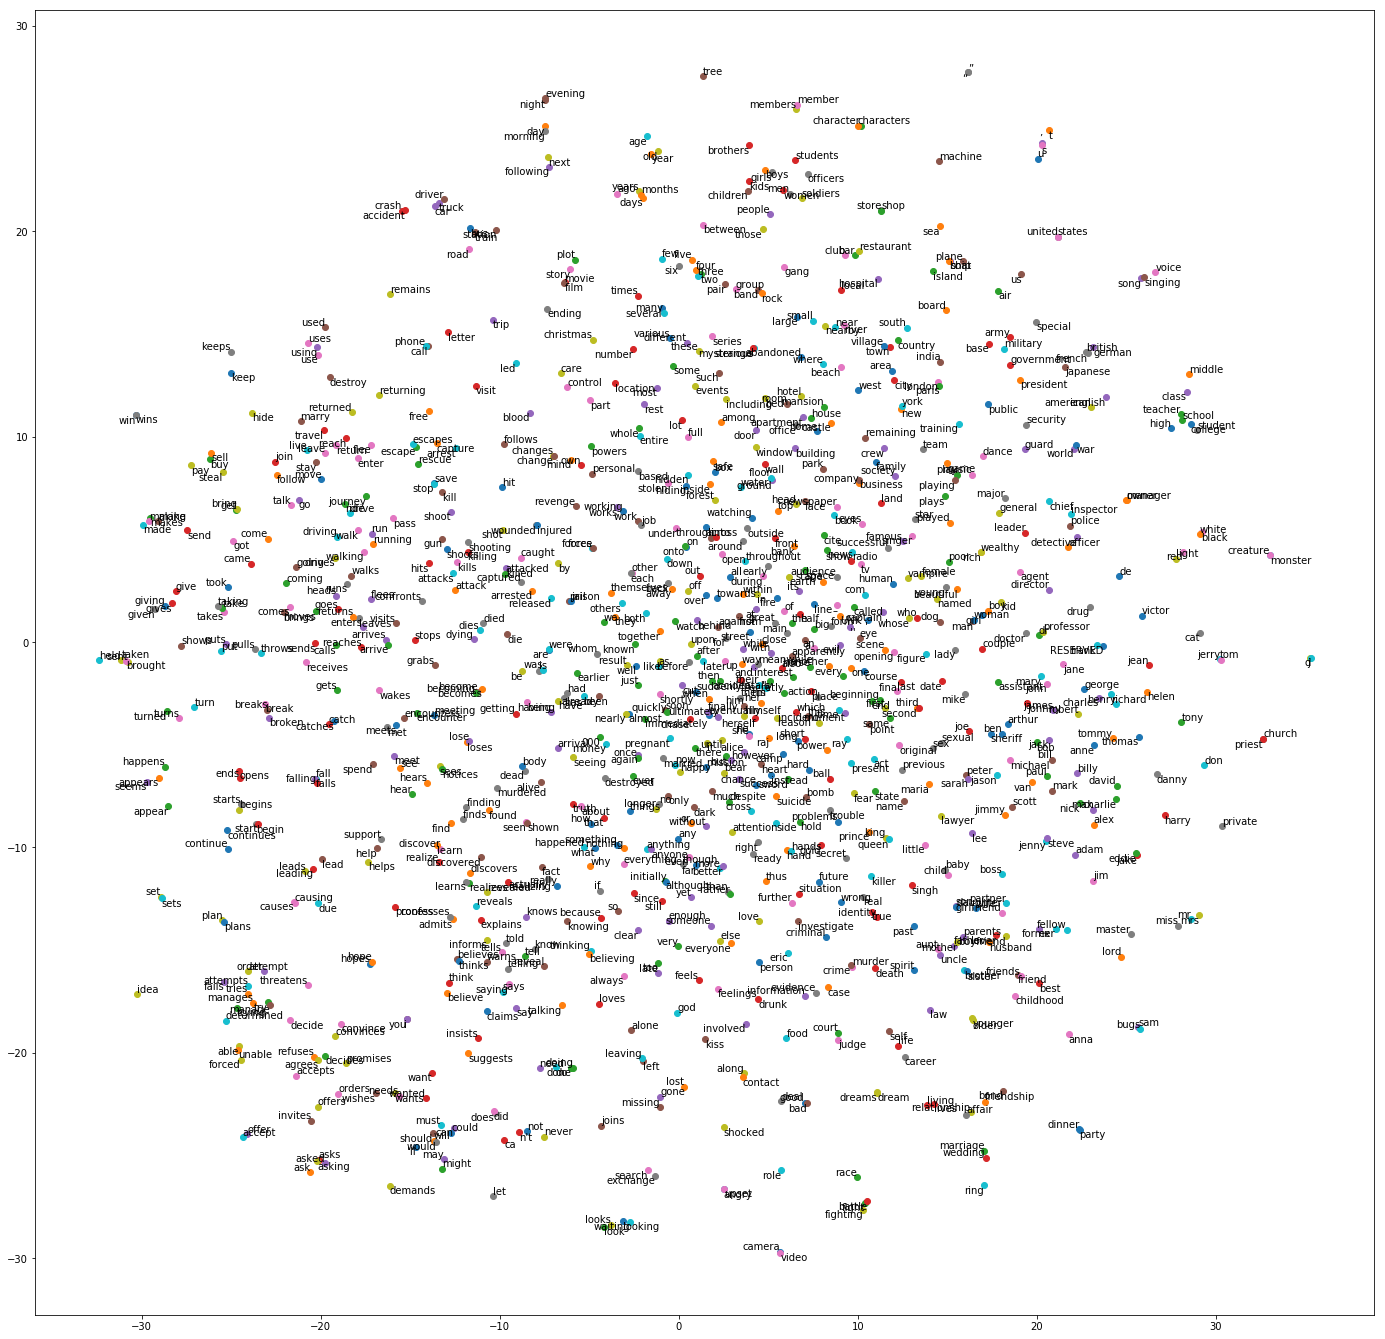

In [25]:
def load_embeddings(filename):
    print('Loading the word embeddings from the disk')
    embed_df = pd.read_csv(os.path.join('wiki',filename), index_col=False, header=None)
    embed_df = embed_df.set_index(0).iloc[:1000]
    print('Embedding shape: {}'.format(embed_df.shape))
    embed_mat = embed_df.values
    words = embed_df.index.values
    return embed_mat, words

def get_tsne_embeddings(embed_mat):
    print('Running T-SNE')
    tsne =  TSNE(n_components=2, perplexity=30, init='pca', n_iter=5000)
    tsne_embeds = tsne.fit_transform(embed_mat)
    return tsne_embeds

def plot_embeddings(tsne_embeds, words):
    print('Creating the plot')

    fig = plt.figure(figsize=(24,24))
    ax = fig.add_subplot(111)

    # plot all the embeddings and their corresponding words
    for i, (xy, label) in enumerate(zip(tsne_embeds, words)):

        ax.scatter(xy[0], xy[1])   
        ax.annotate(
            label, xy=(xy[0], xy[1]), xytext=(np.random.randint(1), np.random.randint(1)), textcoords='offset points',
            ha=np.random.choice(['right','left']), 
            va=np.random.choice(['bottom','top']),fontsize=10
        )

    plt.show()
    
embed_mat, words = load_embeddings('sg_embeddings.csv')
tsne_mat = get_tsne_embeddings(embed_mat)
plot_embeddings(tsne_mat, words)

## Beyond Skip-gram: Improving word vectors

* Subsampling
* Unigram candidate sampling

In [36]:

# Use make_sampling_table function to compute the sampling distribution for each word

run_and_eval(docs, tok, tf_loss, tf_opt, tf_best_inds, tf_in, tf_labels, vocab_size, batch_size, sampling_table=sampling_table, filename='sg_sampled_embeddings.csv')

Loss in epoch 0: 3.6060256958007812

 ==========  Similarities summary  ==========
have: reason, avail, does, be, kendall, link, baddies, decides
apartment: josé, itinerant, stephen, spoil, erik, unexpected, script, endangering
in: a, ripe, japanese, condescending, old, suresh, betrays, scales
was: that, not, diane, thillainathan, ravages, suicide, disenchanted, jaguar
UNK: introductions, documentary, abi, sulley, induction, slot, imdb, exclaims
panics: coverage, azoulay, gooder, manta, roemello, corbett, shitou, keystone
lead: comforted, rains, take, packs, murdering, patty, gohan, ashio
former: curses, spoke, costel, lavanya, mitch, burrows, mithun, bouncers
to: him, for, they, honourable, parvati, but, refused, manisha
and: lalu, chandrakanta, entice, thrill, piel, mere, muster, shep
two: akane, arita, mogul, relationship, approval, ambitious, surrogate, hollowed
way: octavian, pity, loves, groceries, opposite, neck, free, according
UNK: introductions, documentary, abi, sulley, indu

Loss in epoch 6: 3.0225656032562256

 ==========  Similarities summary  ==========
have: who, what, any, become, are, since, anything, has
apartment: room, inside, parking, house, engagement, dingy, basement, halifax
in: the, entire, on, now, over, of, for, during
was: had, earlier, tells, reveals, says, told, previously, died
UNK: s, 's, by, who, named, including, lama, leading
panics: knocking, pushes, bleeding, hears, dismisses, ignores, corrects, infidelity
lead: marry, follows, turn, ultimately, make, role, begins, bring
former: whose, named, fellow, longtime, led, visits, by, works
to: and, but, let, eventually, tries, when, the, make
and: the, to, but, while, his, a, is, quickly
two: three, four, were, their, the, several, remaining, are
way: robyn, vedas, desert, mission, alimony, harbor, gerber, knowlton
UNK: s, 's, by, who, named, including, lama, leading
manages: tries, able, allows, free, decides, attempt, manage, escape
from: after, 's, of, meanwhile, on, the, original, an

TypeError: save_embeddings() takes 1 positional argument but 2 were given

In [ ]:
embed_mat, words = load_embeddings('sg_sampled_embeddings.csv')
tsne_mat = get_tsne_embeddings(embed_mat)
plot_embeddings(tsne_mat, words)